## Packages

In [1]:
from datetime import datetime, timedelta
import pandas as pd
import os
from sunpy.net import Fido, attrs as a
from sunpy.timeseries import TimeSeries
from sunpy.timeseries.sources.goes import XRSTimeSeries
import astropy.units as u
from sunkit_instruments.goes_xrs import calculate_temperature_em
import matplotlib.pyplot as plt
import numpy as np
from sunpy.data import manager
import netCDF4 as nc
import os
import pandas as pd
from datetime import datetime, timedelta
import copy
from matplotlib import colormaps
list(colormaps)
#from colorspacious import cspace_converter
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import LogFormatterMathtext
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob

## Funciones gráficas

In [2]:
# Plot with ticks every minute
def plot_fai_and_flare_lines(df_combined, df_fai_selected, df_fai_all, df_flare_data, 
                              flare_start_time, flare_end_time, graphics_dir,
                              ymin=1e-9, ymax=1e-4):
    """
    Plots XRS A and B on a logarithmic scale with vertical lines for FAI events and flare times.
    df_fai_all: all candidate FAI events
    df_fai_selected: FAI events selected by a method
    """
    import matplotlib.dates as mdates
    import os
    
    # Ensure time types
    flare_start_time = pd.to_datetime(flare_start_time)
    flare_end_time = pd.to_datetime(flare_end_time)
    
    print(f"Buscando datos entre: {flare_start_time} y {flare_end_time}")

    # Convert date columns to datetime if they aren't already
    df_combined['date'] = pd.to_datetime(df_combined['date'])
    df_fai_selected['date'] = pd.to_datetime(df_fai_selected['date'])
    df_fai_all['date'] = pd.to_datetime(df_fai_all['date'])
    df_flare_data['StartTime'] = pd.to_datetime(df_flare_data['StartTime'])
    df_flare_data['PeakTime'] = pd.to_datetime(df_flare_data['PeakTime'])
    df_flare_data['EndTime'] = pd.to_datetime(df_flare_data['EndTime'])

    # DEBUG: Verificar rangos de fechas en los dataframes
    print(f"Rango df_combined: {df_combined['date'].min()} a {df_combined['date'].max()}")
    print(f"Rango df_fai_selected: {df_fai_selected['date'].min()} a {df_fai_selected['date'].max()}")
    print(f"Rango df_flare_data PeakTime: {df_flare_data['PeakTime'].min()} a {df_flare_data['PeakTime'].max()}")

    # Filter data based on date column - método más robusto
    mask_combined = (df_combined['date'] >= flare_start_time) & (df_combined['date'] <= flare_end_time)
    df_plot = df_combined.loc[mask_combined].copy()
    
    mask_fai = (df_fai_selected['date'] >= flare_start_time) & (df_fai_selected['date'] <= flare_end_time)
    df_fai_interval = df_fai_selected.loc[mask_fai].copy()

    mask_fai_all = (df_fai_all['date'] >= flare_start_time) & (df_fai_all['date'] <= flare_end_time)
    df_fai_all_interval = df_fai_all.loc[mask_fai_all].copy()


    # DEBUG: Verificar cuántos datos encontramos
    print(f"Datos en df_plot: {len(df_plot)}")
    print(f"Datos en df_fai_interval: {len(df_fai_interval)}")

    # Si no hay datos en el rango, mostrar advertencia
    if len(df_plot) == 0:
        print(f"¡ADVERTENCIA! No hay datos en df_combined para el rango {flare_start_time} a {flare_end_time}")
        return

    plt.rcParams.update({
        "axes.titlesize": 16, "axes.labelsize": 16, 
        "xtick.labelsize": 15, "ytick.labelsize": 15, 
        "legend.fontsize": 13
    })

    # Create figure
    fig, ax = plt.subplots(figsize=(13, 5))

    # Plot XRS A and B usando el índice numérico para evitar problemas con fechas
    x_vals = range(len(df_plot))  # Usar índice numérico para el plotting
    ax.plot(x_vals, df_plot['xrsa'], label='XRS A', color='blue', linewidth=1)
    ax.plot(x_vals, df_plot['xrsb'], label='XRS B', color='red', linewidth=1)

    # Log scale and Y-axis limits
    ax.set_yscale('log')
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel('X-ray Flux [W/m²]')
    ax.set_xlabel(f"Time [UTC] – {flare_start_time:%d %b %Y}")
    ax.set_title(f'XRS A and B with FAI and Flare Times\n{flare_start_time:%Y-%m-%d %H:%M} to {flare_end_time:%H:%M}')
    ax.grid(True, alpha=0.3)
    
    # -----------------------
    # Configure X axis ticks
    # -----------------------
    # Crear un array de minutos dentro del intervalo de flare
    start_time = flare_start_time
    end_time = flare_end_time

    # Generar ticks mayores cada 10 minutos
    major_times = pd.date_range(start=start_time.ceil('10min'), end=end_time, freq='10min')
    major_indices = [(np.abs(df_plot['date'] - t)).argmin() for t in major_times]
    major_labels = [t.strftime('%H:%M') for t in major_times]

    # Generar ticks menores cada 1 minuto
    minor_times = pd.date_range(start=start_time.ceil('1min'), end=end_time, freq='1min')
    minor_indices = [(np.abs(df_plot['date'] - t)).argmin() for t in minor_times]

    # Asignar ticks al eje X
    ax.set_xticks(major_indices)
    ax.set_xticklabels(major_labels)
    ax.set_xticks(minor_indices, minor=True)  # minor ticks sin etiquetas
    

    # -----------------------
    # Plot all FAI candidates (background)
    # -----------------------
    for i, fai_time in enumerate(df_fai_all_interval['date']):
        idx = (np.abs(df_plot['date'] - fai_time)).argmin()
        ax.axvline(x=idx, color='#FF69B4', linestyle='-', linewidth=1.5, alpha=0.7,
                   label='FAI Candidate' if i == 0 else "")


    # Red vertical lines: FAI events
    for fai_time in df_fai_interval['date']:
        # Encontrar la posición en el plot para este tiempo FAI
        time_diff = np.abs(df_plot['date'] - fai_time)
        if len(time_diff) > 0:
            idx = time_diff.argmin()
            ax.axvline(x=idx, color='red', linestyle='-', linewidth=1.5, alpha=0.7,
                      label='FAI Alert' if fai_time == df_fai_interval['date'].iloc[0] else "")

    # Encontrar fulguraciones en el intervalo de tiempo
    flares_in_interval = df_flare_data[
        (df_flare_data['PeakTime'] >= flare_start_time) & 
        (df_flare_data['PeakTime'] <= flare_end_time)
    ]
    
    print(f"Fulguraciones encontradas en el intervalo: {len(flares_in_interval)}")

    # Colores y estilos para los diferentes tiempos de las fulguraciones
    for idx, (_, row) in enumerate(flares_in_interval.iterrows()):
        start_time = row['StartTime']
        peak_time = row['PeakTime']
        end_time = row['EndTime']
        flare_class = row.get('Class', '')
        
        # Función para encontrar la posición en el plot
        def find_time_position(time_val):
            time_diff = np.abs(df_plot['date'] - time_val)
            if len(time_diff) > 0:
                return time_diff.argmin()
            return None
        
        # Línea verde punteada para StartTime
        if flare_start_time <= start_time <= flare_end_time:
            start_pos = find_time_position(start_time)
            if start_pos is not None:
                ax.axvline(x=start_pos, color='green', linestyle=(0, (5, 3)), linewidth=2, alpha=0.8,
                          label='Flare Start' if idx == 0 else "")
        
        # Línea azul discontinua para PeakTime
        if flare_start_time <= peak_time <= flare_end_time:
            peak_pos = find_time_position(peak_time)
            if peak_pos is not None:
                #ax.axvline(x=peak_pos, color='blue', linestyle='--', linewidth=2, alpha=0.8,
                ax.axvline(x=peak_pos, color='blue', linestyle=(0, (5, 3)), linewidth=2, alpha=0.8,
                          label='Flare Peak' if idx == 0 else "")
                
                # AÑADIR FLECHA QUE SEÑALA EL PEAK
                # Encontrar el valor de flujo en el peak time
                peak_flux = None
                peak_time_diff = np.abs(df_plot['date'] - peak_time)
                if len(peak_time_diff) > 0:
                    peak_idx = peak_time_diff.argmin()
                    # Usar el mayor flujo entre XRS A y XRS B
                    peak_flux = max(df_plot['xrsa'].iloc[peak_idx], df_plot['xrsb'].iloc[peak_idx])
                

        
        # Línea amarilla punteada para EndTime
        if flare_start_time <= end_time <= flare_end_time:
            end_pos = find_time_position(end_time)
            if end_pos is not None:
                ax.axvline(x=end_pos, color='orange', linestyle='--', linewidth=3, alpha=0.8,
                          label='Flare End' if idx == 0 else "")
        
        # Anotación con la clase de la fulguración Y FLECHA
        if flare_class and (flare_start_time <= peak_time <= flare_end_time):
            peak_pos = find_time_position(peak_time)
            if peak_pos is not None:
                ax.annotate(flare_class,
                            xy=(peak_pos, ymin * 5),  # Punto destino
                            xytext=(peak_pos + 1, ymin * 15),  # Punto origen (más a la derecha y arriba)
                            fontsize=9,
                            color='darkblue',
                            rotation=0,
                            ha='left',
                            va='center',
                            bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", ec="darkblue", lw=1, alpha=0.8),
                            arrowprops=dict(arrowstyle='->',  # Flecha
                                          color='darkblue',
                                          lw=1,
                                          alpha=0.7,
                                          shrinkA=5,  # Espacio en el origen
                                          shrinkB=0))  # Sin espacio en el destino

    # Final layout with proper legend handling
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Remove duplicates
    ax.legend(by_label.values(), by_label.keys(), loc="upper right")
    

    fig.tight_layout()

    # Create graphics directory if it doesn't exist
    #graphics_dir = "graphics"
    #os.makedirs(graphics_dir, exist_ok=True)

    #en esta función se recibe el directorio como parámetro
    
    output_name = f"FAI_{flare_start_time:%Y%m%d_%H%M}_{flare_end_time:%H%M}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()


#gráfica ce flux vs EM y T
def plot_xrs_vs_te_simple(days, 
                         df_full_valid, 
                         df_flares_valid, 
                         time_column="PeakTime",
                         XRS="xrsb_corr", T="T_cor", EM="EM_cor_norm",
                         color_by=None,
                         palette="viridis",  
                         class_to_color=None):
    """
    Versión simplificada que asume que podemos hacer merge por tiempo
    """
    
    # Convertir a datetime
    df_full_valid['date'] = pd.to_datetime(df_full_valid['date'])
    df_flares_valid[time_column] = pd.to_datetime(df_flares_valid[time_column])
    
    # Hacer merge de los dataframes
    df_merged = pd.merge(df_flares_valid, df_full_valid, 
                        left_on=time_column, 
                        right_on='date', 
                        how='inner')
    
    if len(df_merged) == 0:
        print("No hay coincidencias entre los dataframes.")
        return
    
    # Filtrar datos válidos
    valid_data = df_merged.dropna(subset=[XRS, T, EM])
    
    if len(valid_data) == 0:
        print("No hay datos válidos después de filtrar NaNs.")
        return
    
    print(f"Datos válidos para graficar: {len(valid_data)}")
    
    # Preparar datos
    xrs_vals = valid_data[XRS].values
    em_vals = valid_data[EM].values
    t_vals = valid_data[T].values
    
    # Preparar labels para colores
    if color_by == "Class":
        flare_labels = valid_data["Class"].astype(str).str[0].tolist()  # solo letra B,C,M,X
    elif color_by == "Date":
        flare_labels = valid_data[time_column].dt.date.astype(str).tolist()
    elif color_by == "observatory":
        flare_labels = valid_data["observatory"].fillna("Unknown").tolist()
    else:
        flare_labels = [""] * len(valid_data)

    # --- Colores según selección ---
    if color_by:
        labels = sorted(set(flare_labels))
        if class_to_color is None:
            cmap = plt.get_cmap(palette, len(labels))
            class_to_color = {lab: cmap(i) for i, lab in enumerate(labels)}
        colors = [class_to_color[lab] for lab in flare_labels]
    else:
        labels = []
        colors = "blue"

    # Configuración de plot
    plt.rcParams.update({
        "axes.titlesize": 17, "axes.labelsize": 15,
        "xtick.labelsize": 16, "ytick.labelsize": 16,
        "legend.fontsize": 16
    })

    fig, axes = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True)

    # XRS vs EM
    axes[0].scatter(em_vals, xrs_vals, c=colors, alpha=0.7, s=50)
    axes[0].set_xlabel(rf"EM$_{{49}}$ [cm$^{{-3}}$]")
    axes[0].set_ylabel(rf"{XRS} [W/m$^2$]")
    axes[0].set_title(f"X-ray flux vs Emission Measure\n{days} days ({time_column})", pad=20)
    axes[0].set_xscale("log")
    axes[0].set_yscale("log")
    axes[0].set_xlim(0.001, None)
    
    # XRS vs T
    axes[1].scatter(t_vals, xrs_vals, c=colors, alpha=0.7, s=50)
    axes[1].set_xlabel(f"T [MK]")
    axes[1].set_ylabel(rf"{XRS} [W/m$^2$]")
    axes[1].set_title(f"X-ray flux vs Temperature\n{days} days ({time_column})", pad=20)
    axes[1].set_xscale("linear")
    axes[1].set_yscale("log")
    axes[1].set_xlim(0, 30)

    # Leyenda
    if color_by and labels:
        handles = [plt.Line2D([], [], marker="o", color=class_to_color[lab], linestyle="", 
                             label=str(lab), markersize=12) for lab in labels]
        
        n_labels = len(labels)

        # Obtener posición de los subplots combinados (en coordenadas de la figura)
        pos0 = axes[0].get_position()
        pos1 = axes[1].get_position()
        subplot_left = pos0.x0
        subplot_right = pos1.x1
        subplot_width = subplot_right - subplot_left
        
        # Número de columnas dinámico según ancho de subplots
        items_per_row = max(1, int(subplot_width * 12))  # escala arbitraria, ajustar si se quiere
        ncol = min(n_labels, items_per_row)
        n_rows = int(np.ceil(n_labels / ncol))

        fig.legend(handles=handles, title=color_by,
                  loc="upper center", bbox_to_anchor=(0.5, -0.05),
                  ncol=min(4, len(labels)), frameon=False,
                  title_fontsize=17) #tamaño de título

    # Guardar
    output_name = f"{days}d_{XRS}_vs_{T}_{EM}_{time_column}_{color_by}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()


##

## Carpeta para gráficas

In [3]:
n=185
window_minutes=30
fai_temp_range = (7, 14)
fai_em_threshold = 0.005
date_column = "date"
duration = True
FAI_duration = 3
filter_flare_coincidence = True
method = "filtered" # "all", "true" o "filtered"

# Obtener fecha actual en formato YYYY-MM-DD
#fecha_actual = datetime.now().strftime("%Y-%m-%d")
fecha_actual = "2025-11-04"
window_minutes=30
output_dir = f"{fecha_actual}_Analysis_for_{n}_days/GraphicsFAI(W_{window_minutes})_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{duration}_{FAI_duration}"

folder = f"Graphics_{method}"

# Crear subcarpeta para guardar resultados de análisis
graphics_dir = os.path.join(output_dir, folder)
# Crear subcarpeta para guardar resultados de análisis (si no existe) y mostrar mensaje
if os.path.exists(graphics_dir):
    print(f"⚠️ La carpeta de análisis ya existía: {graphics_dir}")
else:
    os.makedirs(graphics_dir , exist_ok=True)
    print(f"📁 Carpeta de análisis creada: {graphics_dir}")



⚠️ La carpeta de análisis ya existía: 2025-11-04_Analysis_for_185_days/GraphicsFAI(W_30)_T7-14_EM0.005_durTrue_3/Graphics_filtered


## llamar datos

In [4]:
# Path of cleaned data in csv
csv_path_full_valid = f"{fecha_actual}_Analysis_for_{n}_days/df_full_{n}_valid.csv"
# Path of valid flares: 
csv_path_flares = f"{fecha_actual}_Analysis_for_{n}_days/df_flares_{n}_valid.csv"
# Path of df_full
csv_path_full = f"{fecha_actual}_Analysis_for_{n}_days/df_full_goes_{n}.csv"


# Path of anticipation_time
csv_path_anticipation_time = f"{fecha_actual}_Analysis_for_{n}_days/Analysis_FAI/df_anticipation_time_{method}_(W_{window_minutes})_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"
# Path of fai_all
csv_path_fai_all = f"{fecha_actual}_Analysis_for_{n}_days/Analysis_FAI/df_fai_all_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"
# Path of fai_selected
csv_path_fai_selected = f"{fecha_actual}_Analysis_for_{n}_days/Analysis_FAI/df_fai_{method}_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"
# Path of df_fai_assoc
csv_path_fai_assoc = f"{fecha_actual}_Analysis_for_{n}_days/Analysis_FAI/df_fai_assoc_{method}_(W_{window_minutes})_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"

df_full_valid = pd.read_csv(csv_path_full_valid)
df_flares_valid = pd.read_csv(csv_path_flares)
df_anticipation_time = pd.read_csv(csv_path_anticipation_time)
df_fai_all = pd.read_csv(csv_path_fai_all)
df_fai_selected = pd.read_csv(csv_path_fai_selected)
df_full = pd.read_csv(csv_path_full)
df_fai_assoc = pd.read_csv(csv_path_fai_assoc)

## Info dfs

In [5]:
df_full_valid["date"] = pd.to_datetime(df_full_valid["date"])
df_flares_valid["StartTime"] = pd.to_datetime(df_flares_valid["StartTime"])
df_flares_valid["PeakTime"]  = pd.to_datetime(df_flares_valid["PeakTime"])
df_flares_valid["EndTime"]   = pd.to_datetime(df_flares_valid["EndTime"])
df_anticipation_time["StartTime"] = pd.to_datetime(df_anticipation_time["StartTime"])
df_anticipation_time["PeakTime"]  = pd.to_datetime(df_anticipation_time["PeakTime"])
df_anticipation_time["EndTime"]   = pd.to_datetime(df_anticipation_time["EndTime"])
df_fai_selected["date"] = pd.to_datetime(df_fai_selected["date"])

In [6]:
df_full_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64604 entries, 0 to 64603
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   GOES_ID       64604 non-null  object        
 1   date          64604 non-null  datetime64[ns]
 2   observatory   64604 non-null  object        
 3   xrsa          64604 non-null  float64       
 4   xrsb          64604 non-null  float64       
 5   xrsa_corr     64604 non-null  float64       
 6   xrsb_corr     64604 non-null  float64       
 7   T_cor         64604 non-null  float64       
 8   EM_cor        64604 non-null  float64       
 9   T_phot        64604 non-null  float64       
 10  EM_phot       64604 non-null  float64       
 11  EM_cor_norm   64604 non-null  float64       
 12  EM_phot_norm  64604 non-null  float64       
dtypes: datetime64[ns](1), float64(10), object(2)
memory usage: 6.4+ MB


In [7]:
df_flares_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2020 entries, 0 to 2019
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Flare_ID     2020 non-null   object        
 1   StartTime    2020 non-null   datetime64[ns]
 2   PeakTime     2020 non-null   datetime64[ns]
 3   EndTime      2020 non-null   datetime64[ns]
 4   Class        2020 non-null   object        
 5   ClassLetter  2020 non-null   object        
 6   ClassNumber  2020 non-null   float64       
 7   ClassGroup   2020 non-null   object        
 8   Observatory  2020 non-null   object        
 9   StartPeak    2020 non-null   float64       
 10  PeakEnd      2020 non-null   float64       
 11  StartEnd     2020 non-null   float64       
dtypes: datetime64[ns](3), float64(4), object(5)
memory usage: 189.5+ KB


In [8]:
df_anticipation_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2020 entries, 0 to 2019
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Flare_ID                    2020 non-null   object        
 1   StartTime                   2020 non-null   datetime64[ns]
 2   PeakTime                    2020 non-null   datetime64[ns]
 3   EndTime                     2020 non-null   datetime64[ns]
 4   Class                       2020 non-null   object        
 5   ClassLetter                 2020 non-null   object        
 6   ClassNumber                 2020 non-null   float64       
 7   ClassGroup                  2020 non-null   object        
 8   Observatory                 2020 non-null   object        
 9   StartPeak                   2020 non-null   float64       
 10  PeakEnd                     2020 non-null   float64       
 11  StartEnd                    2020 non-null   float64     

In [9]:
df_fai_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17308 entries, 0 to 17307
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   GOES_ID              17308 non-null  object        
 1   date                 17308 non-null  datetime64[ns]
 2   observatory          17308 non-null  object        
 3   xrsa                 17308 non-null  float64       
 4   xrsb                 17308 non-null  float64       
 5   xrsa_corr            17308 non-null  float64       
 6   xrsb_corr            17308 non-null  float64       
 7   T_cor                17308 non-null  float64       
 8   EM_cor               17308 non-null  float64       
 9   T_phot               17308 non-null  float64       
 10  EM_phot              17308 non-null  float64       
 11  EM_cor_norm          17308 non-null  float64       
 12  EM_phot_norm         17308 non-null  float64       
 13  FAI_alert            17308 non-

In [10]:
df_fai_assoc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17308 entries, 0 to 17307
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GOES_ID              17308 non-null  object 
 1   date                 17308 non-null  object 
 2   observatory          17308 non-null  object 
 3   xrsa                 17308 non-null  float64
 4   xrsb                 17308 non-null  float64
 5   xrsa_corr            17308 non-null  float64
 6   xrsb_corr            17308 non-null  float64
 7   T_cor                17308 non-null  float64
 8   EM_cor               17308 non-null  float64
 9   T_phot               17308 non-null  float64
 10  EM_phot              17308 non-null  float64
 11  EM_cor_norm          17308 non-null  float64
 12  EM_phot_norm         17308 non-null  float64
 13  FAI_alert            17308 non-null  bool   
 14  FAI_true             17308 non-null  bool   
 15  delta_min            17308 non-null 

## Búsqueda individual

In [11]:
pd.set_option('display.max_columns', None)
df_fai_assoc.iloc[:3]

,GOES_ID,date,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm,FAI_alert,FAI_true,delta_min,group_id,duration_from_start,Time_FAI,Associated_Flare,Flare_ID,F_StartTime,F_PeakTime,F_EndTime,F_Class,F_ClassLetter,F_ClassNumber,F_ClassGroup,F_Observatory,F_StartPeak,F_PeakEnd,F_StartEnd,Association_Type,Time_to_flare,FAI_to_start,FAI_to_peak,FAI_to_end
0,GOES_10,2000-06-06 00:17:00,GOES-16,4.194724e-08,0.000001,2.585677e-08,2.906549e-07,11.058271,1.937464e+47,9.953444,5.260247e+47,0.019375,0.052602,True,True,1.0,3,2.0,2000-06-06 00:17:00,True,Flare_20000606_0,2000-06-06 00:28:00,2000-06-06 00:43:00,2000-06-06 00:55:00,C4.6,C,4.6,C1-4.9,GOES,15.0,12.0,27.0,PeakTime,26.0,11.0,26.0,38.0
1,GOES_13,2000-06-06 00:25:00,GOES-16,4.753495e-08,0.000001,8.936986e-09,1.561961e-07,9.086959,1.344306e+47,8.010274,4.128245e+47,0.013443,0.041282,True,True,1.0,4,2.0,2000-06-06 00:25:00,True,Flare_20000606_0,2000-06-06 00:28:00,2000-06-06 00:43:00,2000-06-06 00:55:00,C4.6,C,4.6,C1-4.9,GOES,15.0,12.0,27.0,PeakTime,18.0,3.0,18.0,30.0
2,GOES_14,2000-06-06 00:26:00,GOES-16,5.612609e-08,0.000001,1.455322e-08,2.010820e-07,10.094641,1.496619e+47,8.974755,4.320921e+47,0.014966,0.043209,True,True,1.0,4,3.0,2000-06-06 00:26:00,True,Flare_20000606_0,2000-06-06 00:28:00,2000-06-06 00:43:00,2000-06-06 00:55:00,C4.6,C,4.6,C1-4.9,GOES,15.0,12.0,27.0,PeakTime,17.0,2.0,17.0,29.0


In [12]:
df_anticipation_time.sort_values(by="FAIalerts_W", ascending=False)[:2]

,Flare_ID,StartTime,PeakTime,EndTime,Class,ClassLetter,ClassNumber,ClassGroup,Observatory,StartPeak,PeakEnd,StartEnd,FAIalerts_W,FAIalerts_WStart,FAIalerts_WPeak,FAIalerts_StartPeak,FAIalerts_PeakEnd,FAIalerts_startEnd,AnticipationStart,AnticipationPeak,Peak_to_lastFAI,Time_since_prev_flare_end,Time_since_prev_flare_peak,RelAnticipation_Peak,RelAnticipation_Start
874,Flare_20131028_874,2013-10-28 11:32:00,2013-10-28 11:53:00,2013-10-28 12:39:00,M1.4,M,1.4,M1-4.9,GOES,21.0,46.0,67.0,29,8,29,21,0,21,8.0,29.0,1.0,147.0,151.0,1.380952,0.380952
1025,Flare_20141026_1025,2014-10-26 17:08:00,2014-10-26 17:17:00,2014-10-26 17:30:00,M1.0,M,1.0,M1-4.9,GOES,9.0,13.0,22.0,28,19,28,9,0,9,19.0,28.0,1.0,55.0,60.0,3.111111,2.111111


In [13]:
#flare_id = "Flare_20000606_0"
#df_fai_assoc[df_fai_assoc["Flare_ID"] == flare_id]


## Prueba T vs EM

In [14]:
def plot_temperature_vs_emission_advanced(df, 
                                        flare_start_time=None,
                                        flare_end_time=None,
                                        highlight_start_time=None,
                                        highlight_end_time=None,
                                        use_corrected=True,
                                        observatory=None,
                                        graphics_dir=None,
                                        filename=None,
                                        xlim=None,
                                        ylim=None,
                                        figsize=(12, 8),
                                        dpi=300):
    """
    Scatter plot avanzado de Temperatura vs Medida de Emisión con múltiples opciones
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame con datos solares
    flare_start_time, flare_end_time : timestamp, optional
        Rango de tiempo completo del flare para filtrar datos
    highlight_start_time, highlight_end_time : timestamp, optional
        Rango de tiempo específico para resaltar con paleta de colores
    use_corrected : bool
        Si usar valores corregidos (T_cor, EM_cor) o fotosféricos (T_phot, EM_phot)
    observatory : str, optional
        Filtro por observatorio
    graphics_dir : str, optional
        Directorio donde guardar la gráfica
    filename : str, optional
        Nombre del archivo para guardar
    xlim : tuple, optional
        Límites del eje x (min, max)
    ylim : tuple, optional
        Límites del eje y (min, max)
    figsize : tuple
        Tamaño de la figura
    dpi : int
        Resolución para guardar la imagen
    """
    
    # Filtrar datos por observatorio
    df_plot = df.copy()
    
    if observatory:
        df_plot = df_plot[df_plot['observatory'] == observatory]
    
    # Filtrar por rango del flare si se especifica
    if flare_start_time is not None:
        df_plot = df_plot[df_plot['date'] >= flare_start_time]
    
    if flare_end_time is not None:
        df_plot = df_plot[df_plot['date'] <= flare_end_time]
    
    if len(df_plot) == 0:
        print("No hay datos después del filtrado")
        return None, None
    
    # Seleccionar columnas
    if use_corrected:
        temp_col = 'T_cor'
        em_col = 'EM_cor'
        data_type = "corregidos"
    else:
        temp_col = 'T_phot'
        em_col = 'EM_phot'
        data_type = "fotosfericos"
    
    # Crear figura
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot todos los puntos en gris (fondo)
    background_scatter = ax.scatter(df_plot[em_col], df_plot[temp_col],
                                   c='gray', alpha=0.3, s=15, 
                                   label='Todos los datos')
    
    # Preparar datos para resaltar
    if highlight_start_time is not None and highlight_end_time is not None:
        # Resaltar un rango de tiempo específico con paleta de colores
        highlight_df = df_plot[(df_plot['date'] >= highlight_start_time) & 
                              (df_plot['date'] <= highlight_end_time)]
        
        if len(highlight_df) > 0:
            # Convertir tiempo a numérico para el color (normalizado entre 0 y 1)
            time_numeric = (highlight_df['date'] - highlight_start_time).dt.total_seconds()
            time_normalized = time_numeric / time_numeric.max()
            
            scatter = ax.scatter(highlight_df[em_col], highlight_df[temp_col],
                               c=time_normalized,
                               cmap='plasma',
                               alpha=0.8,
                               s=40,
                               edgecolors='black',
                               linewidths=0.5,
                               label='Rango resaltado')
            
            # Añadir colorbar para el rango resaltado
            cbar = plt.colorbar(scatter, ax=ax)
            cbar.set_label('Tiempo en rango resaltado (segundos)', fontsize=10)
            
            # Añadir etiquetas a la colorbar con tiempos reales
            ticks = cbar.get_ticks()
            if len(ticks) > 0:
                time_labels = [f"{(tick * time_numeric.max()):.0f}s" for tick in ticks]
                cbar.set_ticks(ticks)
                cbar.set_ticklabels(time_labels)
    
    # Configurar ejes
    ax.set_xlabel(r'Medida de Emisión (cm$^{-3}$)', fontsize=12)
    ax.set_ylabel('Temperatura (MK)', fontsize=12)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    
    # Aplicar límites de ejes si se especifican
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    
    # Crear título informativo
    title_parts = [f'Temperatura vs Medida de Emisión ({data_type})']
    
    if flare_start_time is not None and flare_end_time is not None:
        title_parts.append(f'Flare: {flare_start_time.strftime("%Y-%m-%d %H:%M")} - {flare_end_time.strftime("%H:%M")}')
    
    if highlight_start_time is not None and highlight_end_time is not None:
        title_parts.append(f'Resaltado: {highlight_start_time.strftime("%H:%M:%S")} - {highlight_end_time.strftime("%H:%M:%S")}')
    
    if observatory:
        title_parts.append(f'Observatorio: {observatory}')
    
    ax.set_title('\n'.join(title_parts), fontsize=14)
    ax.legend()
    
    plt.tight_layout()
    
    # Guardar la gráfica si se especifica directorio
    if graphics_dir and filename:
        # Crear directorio si no existe
        os.makedirs(graphics_dir, exist_ok=True)
        
        # Asegurar que el filename tenga extensión .png
        if not filename.lower().endswith('.png'):
            filename += '.png'
        
        full_path = os.path.join(graphics_dir, filename)
        plt.savefig(full_path, dpi=dpi, bbox_inches='tight')
        print(f"Gráfica guardada en: {full_path}")
    
    plt.show()
    
    return fig, ax

# Función adicional para crear múltiples gráficas automáticamente
def create_flare_analysis_plots(df, flare_info_list, graphics_dir='./graphics/', use_corrected=True):
    """
    Crear múltiples gráficas para diferentes flares automáticamente
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame con datos solares
    flare_info_list : list of dict
        Lista con información de cada flare a graficar
        Ejemplo: [{'name': 'SOL2014-01-07', 'start': start_time, 'end': end_time, 
                  'highlight_start': h_start, 'highlight_end': h_end, 'observatory': 'GOES15'}]
    graphics_dir : str
        Directorio donde guardar las gráficas
    use_corrected : bool
        Tipo de datos a usar
    """
    
    os.makedirs(graphics_dir, exist_ok=True)
    
    for flare_info in flare_info_list:
        filename = f"{flare_info['name']}_T_vs_EM.png"
        
        fig, ax = plot_temperature_vs_emission_advanced(
            df=df,
            flare_start_time=flare_info.get('start'),
            flare_end_time=flare_info.get('end'),
            highlight_start_time=flare_info.get('highlight_start'),
            highlight_end_time=flare_info.get('highlight_end'),
            use_corrected=use_corrected,
            observatory=flare_info.get('observatory'),
            graphics_dir=graphics_dir,
            filename=filename,
            xlim=flare_info.get('xlim'),
            ylim=flare_info.get('ylim')
        )



In [15]:
# Ejemplos de uso:

# 1. Uso básico con un flare específico
def plot_sol2014_01_07_example(df_full_valid):
    """Ejemplo para el flare SOL2016-03-28"""
    
    flare_start = pd.Timestamp('2016-03-28 01:00:00')
    flare_end = pd.Timestamp('2016-03-28 03:30:00')
    highlight_start = pd.Timestamp('2016-03-28 02:00:00')
    highlight_end = pd.Timestamp('2016-03-28 03:10:00')
    
    fig, ax = plot_temperature_vs_emission_advanced(
        df=df_full_valid,
        flare_start_time=flare_start,
        flare_end_time=flare_end,
        highlight_start_time=highlight_start,
        highlight_end_time=highlight_end,
        use_corrected=True,
        observatory='GOES15',
        graphics_dir=graphics_dir,
        filename=f'SOL{highlight_start}to{highlight_end}_T_vs_EM_highlight.png',
        xlim=(1e26, 1e30),  # Límites personalizados para eje X
        ylim=(1e6, 1e8),    # Límites personalizados para eje Y
        figsize=(10, 8),
        dpi=300
    )
    
    return fig, ax



In [16]:
plot_sol2014_01_07_example(df_full_valid)

No hay datos después del filtrado


(None, None)

In [17]:
fig, ax = plot_temperature_vs_emission_advanced(
    df=df_full_valid,
    flare_start_time=pd.Timestamp('2016-03-28 01:00:00'),
    flare_end_time=pd.Timestamp('2016-03-28 04:00:00'),
    highlight_start_time=pd.Timestamp('2016-03-28 02:00:00'),
    highlight_end_time=pd.Timestamp('2016-03-28 03:00:00'),
    observatory='GOES-13',
    graphics_dir=graphics_dir,
    filename='my_flare_analysis.png')

No hay datos después del filtrado


In [18]:
# Definir rango con horas, minutos y segundos
fecha_inicio = '2016-03-28 00:00:00'
fecha_fin    = '2016-03-28 05:00:00'

# Filtrar
df_filtrado_full_valid = df_full_valid[
    (df_full_valid['date'] >= fecha_inicio) & 
    (df_full_valid['date'] <= fecha_fin)
]

df_filtrado_full_valid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   GOES_ID       0 non-null      object        
 1   date          0 non-null      datetime64[ns]
 2   observatory   0 non-null      object        
 3   xrsa          0 non-null      float64       
 4   xrsb          0 non-null      float64       
 5   xrsa_corr     0 non-null      float64       
 6   xrsb_corr     0 non-null      float64       
 7   T_cor         0 non-null      float64       
 8   EM_cor        0 non-null      float64       
 9   T_phot        0 non-null      float64       
 10  EM_phot       0 non-null      float64       
 11  EM_cor_norm   0 non-null      float64       
 12  EM_phot_norm  0 non-null      float64       
dtypes: datetime64[ns](1), float64(10), object(2)
memory usage: 0.0+ bytes


### otras pruebas

    # 2. Uso con múltiples flares
    def create_multiple_flare_plots(df_full_valid):
        """Crear gráficas para múltiples flares"""
        
        flare_info_list = [
            {
                'name': 'SOL2014-01-07',
                'start': pd.Timestamp('2014-01-07 10:00:00'),
                'end': pd.Timestamp('2014-01-07 12:00:00'),
                'highlight_start': pd.Timestamp('2014-01-07 10:30:00'),
                'highlight_end': pd.Timestamp('2014-01-07 11:30:00'),
                'observatory': 'GOES15',
                'xlim': (1e26, 1e30),
                'ylim': (1e6, 1e8)
            },
            {
                'name': 'SOL2014-02-15',
                'start': pd.Timestamp('2014-02-15 08:00:00'),
                'end': pd.Timestamp('2014-02-15 10:00:00'),
                'highlight_start': pd.Timestamp('2014-02-15 08:30:00'),
                'highlight_end': pd.Timestamp('2014-02-15 09:30:00'),
                'observatory': 'GOES15',
                'xlim': (1e26, 1e30),
                'ylim': (1e6, 1e8)
            }
        ]
        
        create_flare_analysis_plots(
            df=df_full_valid,
            flare_info_list=flare_info_list,
            graphics_dir='./graphics/flares_analysis/',
            use_corrected=True
        )

    # 3. Uso simple y directo
    # fig, ax = plot_temperature_vs_emission_advanced(
    #     df=df_full_valid,
    #     flare_start_time=pd.Timestamp('2014-01-07 10:00:00'),
    #     flare_end_time=pd.Timestamp('2014-01-07 12:00:00'),
    #     highlight_start_time=pd.Timestamp('2014-01-07 10:45:00'),
    #     highlight_end_time=pd.Timestamp('2014-01-07 11:15:00'),
    #     observatory='GOES15',
    #     graphics_dir='./my_plots/',
    #     filename='my_flare_analysis.png'
    # )

## Analysis flare by flare

Buscando datos entre: 2000-06-06 00:00:00 y 2000-06-06 01:00:00
Rango df_combined: 2000-06-06 00:00:00 a 2025-06-19 23:59:00
Rango df_fai_selected: 2000-06-06 00:17:00 a 2025-06-19 23:46:00
Rango df_flare_data PeakTime: 2000-06-06 00:43:00 a 2025-06-19 19:29:00
Datos en df_plot: 61
Datos en df_fai_interval: 14
Fulguraciones encontradas en el intervalo: 1


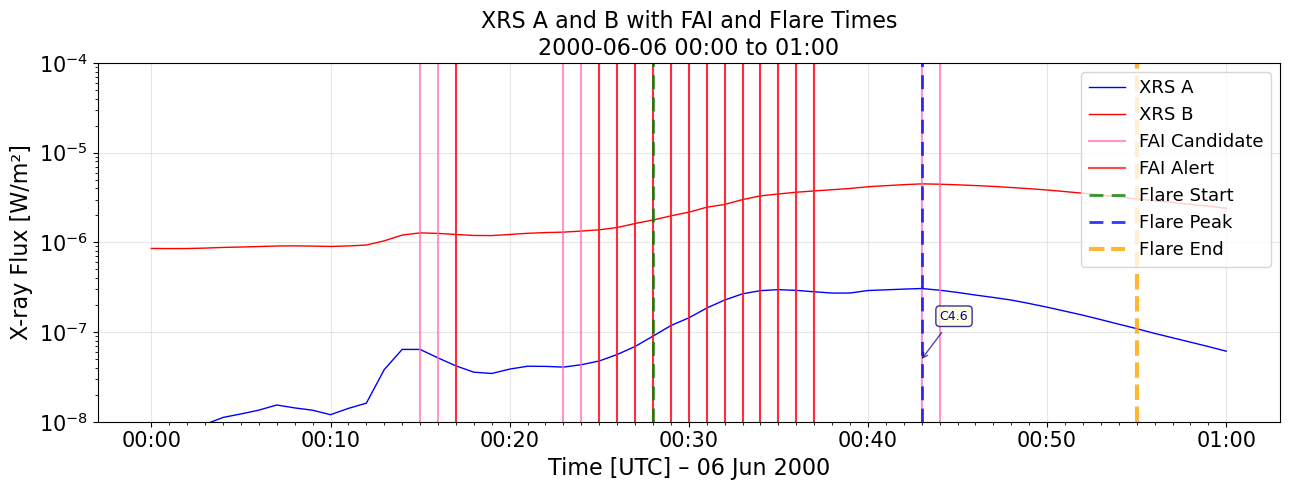

In [19]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_fai_all=df_fai_all,
    df_flare_data=df_flares_valid,
    flare_start_time="2000-06-06 00:00:00",
    flare_end_time="2000-06-06 01:00:00", 
    graphics_dir=graphics_dir,
    ymin=1e-8, ymax=1e-4)

In [20]:
# Definir rango con horas, minutos y segundos
fecha_inicio = '2016-03-28 02:00:00'
fecha_fin    = '2016-03-28 03:00:00'

# Filtrar
df_filtrado_full_valid = df_full_valid[
    (df_full_valid['date'] >= fecha_inicio) & 
    (df_full_valid['date'] <= fecha_fin)
]

df_filtrado_full_valid

,GOES_ID,date,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm


In [21]:
# Definir rango con horas, minutos y segundos
fecha_inicio = '2016-03-28 02:00:00'
fecha_fin    = '2016-03-28 03:00:00'

# Filtrar
df_filtrado_fai_selected = df_fai_selected[
    (df_fai_selected['date'] >= fecha_inicio) & 
    (df_fai_selected['date'] <= fecha_fin)
]

df_filtrado_fai_selected

,GOES_ID,date,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm,FAI_alert,FAI_true,delta_min,group_id,duration_from_start


In [22]:
# Definir rango con horas, minutos y segundos
fecha_inicio = '2016-03-28 02:10:00'
fecha_fin    = '2016-03-28 05:10:00'

# Filtrar
df_filtrado_anticipation_time = df_anticipation_time[
    (df_anticipation_time['StartTime'] >= fecha_inicio) & 
    (df_anticipation_time['StartTime'] <= fecha_fin)
]

print(df_filtrado_anticipation_time)

Empty DataFrame
Columns: [Flare_ID, StartTime, PeakTime, EndTime, Class, ClassLetter, ClassNumber, ClassGroup, Observatory, StartPeak, PeakEnd, StartEnd, FAIalerts_W, FAIalerts_WStart, FAIalerts_WPeak, FAIalerts_StartPeak, FAIalerts_PeakEnd, FAIalerts_startEnd, AnticipationStart, AnticipationPeak, Peak_to_lastFAI, Time_since_prev_flare_end, Time_since_prev_flare_peak, RelAnticipation_Peak, RelAnticipation_Start]
Index: []


Buscando datos entre: 2025-01-04 14:05:00 y 2025-01-04 16:40:00
Rango df_combined: 2000-06-06 00:00:00 a 2025-06-19 23:59:00
Rango df_fai_selected: 2000-06-06 00:17:00 a 2025-06-19 23:46:00
Rango df_flare_data PeakTime: 2000-06-06 00:43:00 a 2025-06-19 19:29:00
Datos en df_plot: 156
Datos en df_fai_interval: 43
Fulguraciones encontradas en el intervalo: 1


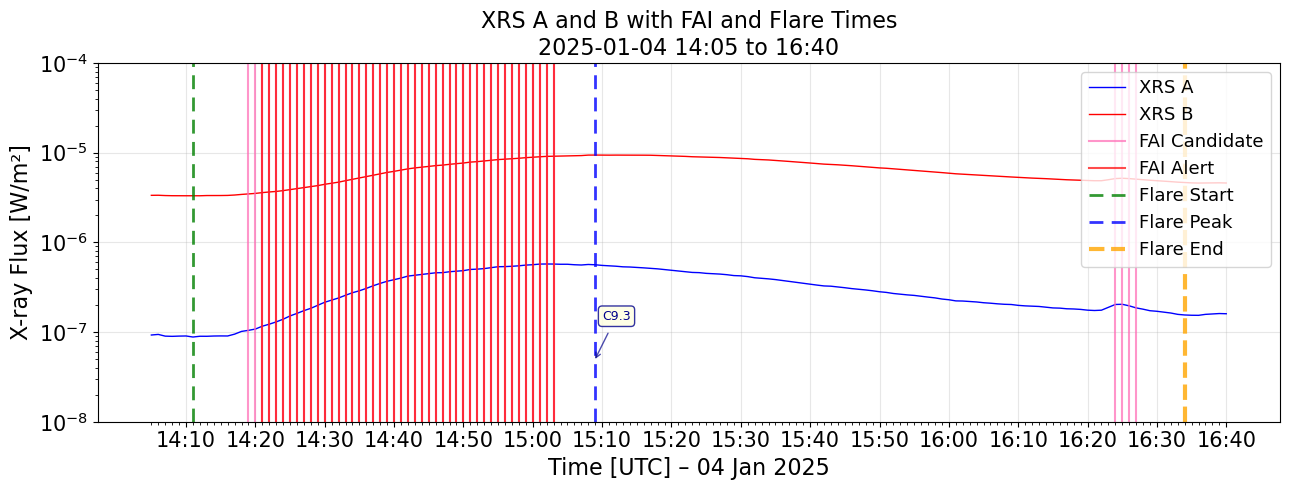

In [23]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_all=df_fai_all,
    df_fai_selected=df_fai_selected,
    df_flare_data=df_flares_valid,
    flare_start_time="2025-01-04 14:05:00",
    flare_end_time="2025-01-04 16:40:00", 
    graphics_dir=graphics_dir,
    ymin=1e-8, ymax=1e-4)

In [24]:
# Definir rango con horas, minutos y segundos
fecha_inicio = '2025-08-28 12:10:00'
fecha_fin    = '2025-08-28 23:59:00'

# Filtrar
df_filtrado_full = df_full[
    (df_full['date'] >= fecha_inicio) & 
    (df_full['date'] <= fecha_fin)
]

df_filtrado_full

,date,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm


In [25]:
df_anticipation_time.sort_values(by="FAIalerts_WStart", ascending=False)[6:10]

,Flare_ID,StartTime,PeakTime,EndTime,Class,ClassLetter,ClassNumber,ClassGroup,Observatory,StartPeak,PeakEnd,StartEnd,FAIalerts_W,FAIalerts_WStart,FAIalerts_WPeak,FAIalerts_StartPeak,FAIalerts_PeakEnd,FAIalerts_startEnd,AnticipationStart,AnticipationPeak,Peak_to_lastFAI,Time_since_prev_flare_end,Time_since_prev_flare_peak,RelAnticipation_Peak,RelAnticipation_Start
821,Flare_20120706_821,2012-07-06 23:01:00,2012-07-06 23:08:00,2012-07-06 23:14:00,X1.1,X,1.1,X1-4.9,GOES,7.0,6.0,13.0,14,14,14,0,0,0,21.0,28.0,11.0,NaN,NaN,4.000000,3.000000
1297,Flare_20230110_1297,2023-01-10 16:02:00,2023-01-10 16:13:00,2023-01-10 16:26:00,C7.3,C,7.3,C5-9.9,GOES,11.0,13.0,24.0,25,14,25,11,0,11,14.0,25.0,1.0,80.0,86.0,2.272727,1.272727
1045,Flare_20141107_1045,2014-11-07 10:13:00,2014-11-07 10:22:00,2014-11-07 10:30:00,M1.0,M,1.0,M1-4.9,GOES,9.0,8.0,17.0,18,13,18,5,0,5,18.0,27.0,5.0,NaN,NaN,3.000000,2.000000
920,Flare_20131119_920,2013-11-19 10:14:00,2013-11-19 10:26:00,2013-11-19 10:34:00,X1.0,X,1.0,X1-4.9,GOES,12.0,8.0,20.0,16,13,16,3,0,3,13.0,25.0,10.0,NaN,NaN,2.083333,1.083333


In [26]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_fai_all=df_fai_all,
    df_flare_data=df_flares_valid,
    flare_start_time="2024-10-28 03:20:00",
    flare_end_time="2024-10-28 04:50:00", 
    graphics_dir=graphics_dir,
    ymin=1e-8, ymax=1e-3)


Buscando datos entre: 2024-10-28 03:20:00 y 2024-10-28 04:50:00
Rango df_combined: 2000-06-06 00:00:00 a 2025-06-19 23:59:00
Rango df_fai_selected: 2000-06-06 00:17:00 a 2025-06-19 23:46:00
Rango df_flare_data PeakTime: 2000-06-06 00:43:00 a 2025-06-19 19:29:00
Datos en df_plot: 0
Datos en df_fai_interval: 0
¡ADVERTENCIA! No hay datos en df_combined para el rango 2024-10-28 03:20:00 a 2024-10-28 04:50:00


Buscando datos entre: 2014-10-26 16:40:00 y 2014-10-26 18:30:00
Rango df_combined: 2000-06-06 00:00:00 a 2025-06-19 23:59:00
Rango df_fai_selected: 2000-06-06 00:17:00 a 2025-06-19 23:46:00
Rango df_flare_data PeakTime: 2000-06-06 00:43:00 a 2025-06-19 19:29:00
Datos en df_plot: 111
Datos en df_fai_interval: 29
Fulguraciones encontradas en el intervalo: 3


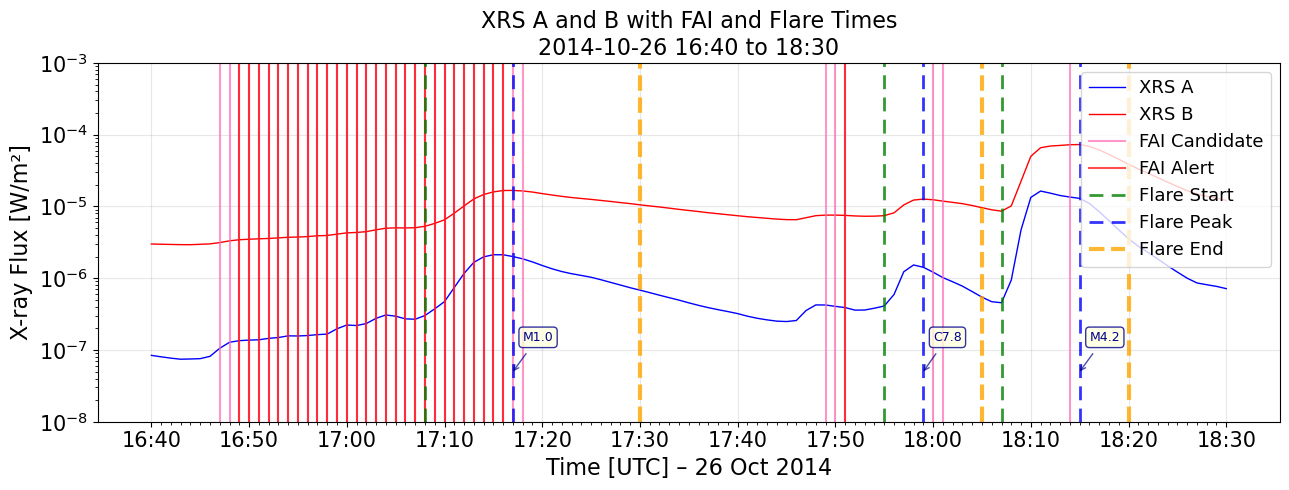

In [27]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_fai_all=df_fai_all,
    df_flare_data=df_flares_valid,
    flare_start_time="2014-10-26 16:40:00",
    flare_end_time="2014-10-26 18:30:00", 
    graphics_dir=graphics_dir,
    ymin=1e-8, ymax=1e-3)

In [28]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_fai_all=df_fai_all,
    df_flare_data=df_flares_valid,
    flare_start_time="1989-06-06 16:00:00",
    flare_end_time="1989-06-06 19:00:00", 
    graphics_dir=graphics_dir,
    ymin=1e-8, ymax=1e-3)

Buscando datos entre: 1989-06-06 16:00:00 y 1989-06-06 19:00:00
Rango df_combined: 2000-06-06 00:00:00 a 2025-06-19 23:59:00
Rango df_fai_selected: 2000-06-06 00:17:00 a 2025-06-19 23:46:00
Rango df_flare_data PeakTime: 2000-06-06 00:43:00 a 2025-06-19 19:29:00
Datos en df_plot: 0
Datos en df_fai_interval: 0
¡ADVERTENCIA! No hay datos en df_combined para el rango 1989-06-06 16:00:00 a 1989-06-06 19:00:00


Buscando datos entre: 2001-11-04 15:00:00 y 2001-11-04 16:00:00
Rango df_combined: 2000-06-06 00:00:00 a 2025-06-19 23:59:00
Rango df_fai_selected: 2000-06-06 00:17:00 a 2025-06-19 23:46:00
Rango df_flare_data PeakTime: 2000-06-06 00:43:00 a 2025-06-19 19:29:00


Datos en df_plot: 61
Datos en df_fai_interval: 24
Fulguraciones encontradas en el intervalo: 1


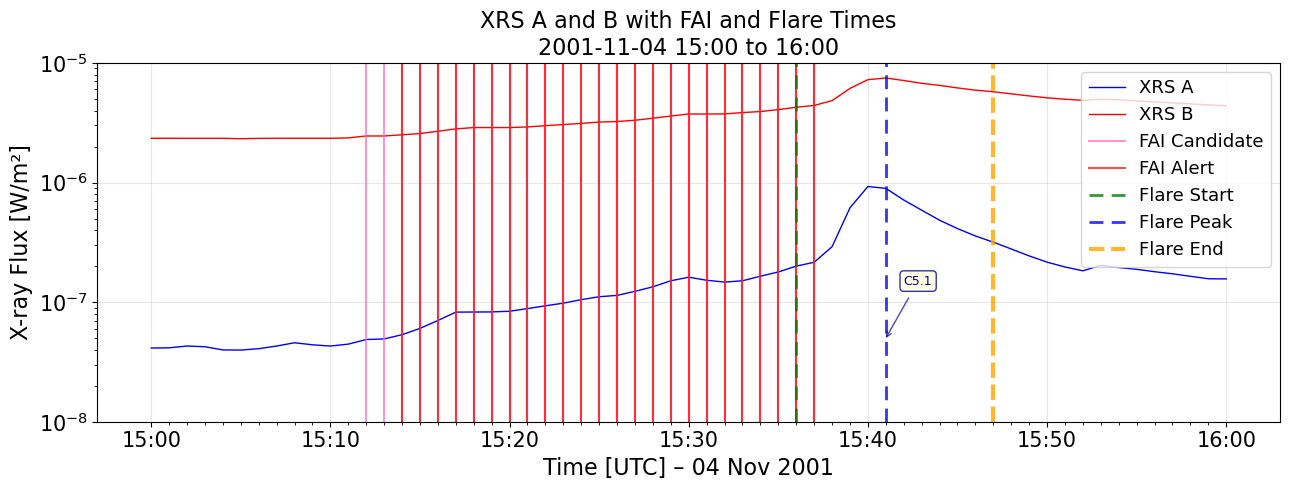

In [29]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_fai_all=df_fai_all,
    df_flare_data=df_flares_valid,
    flare_start_time="2001-11-04 15:00:00",
    flare_end_time="2001-11-04 16:00:00", 
    graphics_dir=graphics_dir,
    ymin=1e-8, ymax=1e-5)

Buscando datos entre: 2025-01-04 14:11:00 y 2025-01-04 16:34:00
Rango df_combined: 2000-06-06 00:00:00 a 2025-06-19 23:59:00
Rango df_fai_selected: 2000-06-06 00:17:00 a 2025-06-19 23:46:00
Rango df_flare_data PeakTime: 2000-06-06 00:43:00 a 2025-06-19 19:29:00
Datos en df_plot: 144
Datos en df_fai_interval: 43
Fulguraciones encontradas en el intervalo: 1


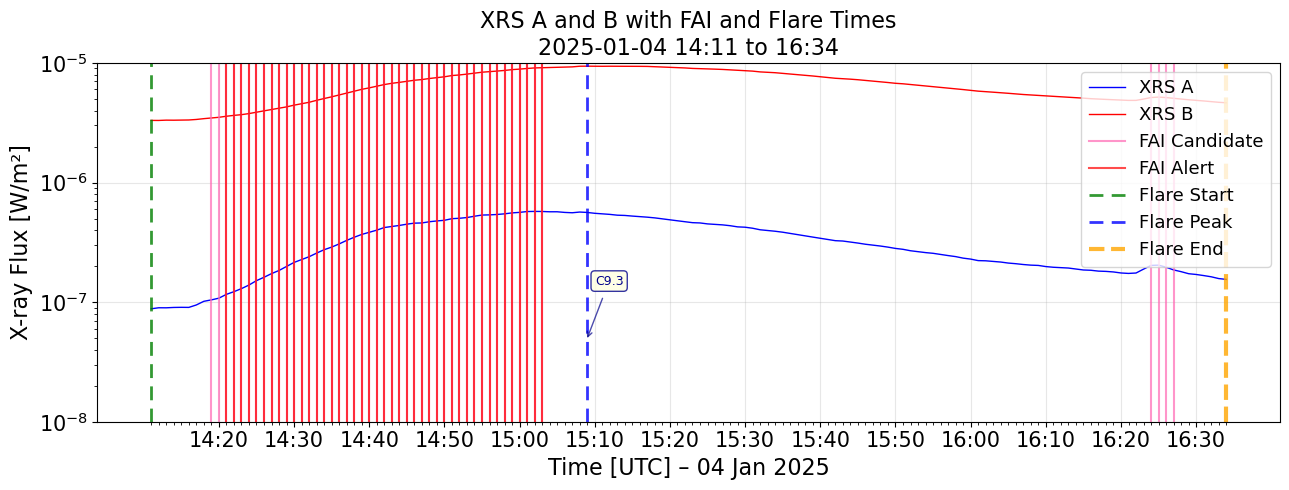

In [30]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_fai_all=df_fai_all,
    df_flare_data=df_flares_valid,
    flare_start_time="2025-01-04 14:11:00",
    flare_end_time="2025-01-04 16:34:00	", 
    graphics_dir=graphics_dir,
    ymin=1e-8, ymax=1e-5)


In [31]:
df_full_valid.head()

,GOES_ID,date,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm
0,GOES_0,2000-06-06 00:05:00,GOES-16,1.220925e-08,8.860234e-07,3.788372e-09,3.142395e-08,12.571802,1.839645e+46,11.630426,4.512600e+46,0.001840,0.004513
1,GOES_1,2000-06-06 00:06:00,GOES-16,1.346536e-08,8.977652e-07,5.258025e-09,4.601407e-08,12.297073,2.748919e+46,11.315239,6.866820e+46,0.002749,0.006867
2,GOES_2,2000-06-06 00:07:00,GOES-16,1.536368e-08,9.099479e-07,7.282076e-09,5.697751e-08,12.875831,3.267130e+46,11.983715,7.855587e+46,0.003267,0.007856
3,GOES_3,2000-06-06 00:08:00,GOES-16,1.425506e-08,9.134990e-07,4.896752e-09,5.101930e-08,11.426795,3.280485e+46,10.346220,8.692047e+46,0.003280,0.008692
4,GOES_4,2000-06-06 00:09:00,GOES-16,1.343720e-08,9.078860e-07,2.276667e-09,3.068232e-08,10.207486,2.251486e+46,9.086091,6.454625e+46,0.002251,0.006455


In [32]:
df_flares_valid.head()

,Flare_ID,StartTime,PeakTime,EndTime,Class,ClassLetter,ClassNumber,ClassGroup,Observatory,StartPeak,PeakEnd,StartEnd
0,Flare_20000606_0,2000-06-06 00:28:00,2000-06-06 00:43:00,2000-06-06 00:55:00,C4.6,C,4.6,C1-4.9,GOES,15.0,12.0,27.0
1,Flare_20000606_1,2000-06-06 01:30:00,2000-06-06 01:49:00,2000-06-06 02:01:00,C2.4,C,2.4,C1-4.9,GOES,19.0,12.0,31.0
2,Flare_20000606_2,2000-06-06 08:06:00,2000-06-06 08:16:00,2000-06-06 08:34:00,C2.8,C,2.8,C1-4.9,GOES,10.0,18.0,28.0
3,Flare_20000606_3,2000-06-06 08:47:00,2000-06-06 08:51:00,2000-06-06 08:54:00,C2.4,C,2.4,C1-4.9,GOES,4.0,3.0,7.0
4,Flare_20000606_4,2000-06-06 11:23:00,2000-06-06 11:27:00,2000-06-06 11:29:00,C1.8,C,1.8,C1-4.9,GOES,4.0,2.0,6.0


## Observatory

In [33]:
# Ver todos los observatorios únicos
print("Observatorios únicos:")
print(df_full_valid['observatory'].unique())

# O en formato de lista
print("\nLista de observatorios:")
print(list(df_full_valid['observatory'].unique()))

Observatorios únicos:
['GOES-16' 'GOES-10' 'GOES-15' 'GOES-14' 'GOES-13' 'GOES-18']

Lista de observatorios:
['GOES-16', 'GOES-10', 'GOES-15', 'GOES-14', 'GOES-13', 'GOES-18']


In [34]:
# Ver observatorios con cantidad de registros
print("Conteo por observatorio:")
print(df_full_valid['observatory'].value_counts())

# Con porcentajes
print("\nPorcentajes por observatorio:")
print(df_full_valid['observatory'].value_counts(normalize=True) * 100)

Conteo por observatorio:
observatory
GOES-16    29158
GOES-10    20449
GOES-13     7298
GOES-15     6006
GOES-18     1447
GOES-14      246
Name: count, dtype: int64

Porcentajes por observatorio:
observatory
GOES-16    45.133428
GOES-10    31.652839
GOES-13    11.296514
GOES-15     9.296638
GOES-18     2.239799
GOES-14     0.380781
Name: proportion, dtype: float64


In [35]:
# Rango de fechas general
print("=== RANGOS DE FECHAS ===")
print(f"Fecha mínima: {df_full_valid['date'].min()}")
print(f"Fecha máxima: {df_full_valid['date'].max()}")

# Por observatorio
for observatorio in df_full_valid['observatory'].unique():
    subset = df_full_valid[df_full_valid['observatory'] == observatorio]
    print(f"\n{observatorio}:")
    print(f"  Desde: {subset['date'].min()}")
    print(f"  Hasta: {subset['date'].max()}")
    print(f"  Registros: {len(subset):,}")

=== RANGOS DE FECHAS ===
Fecha mínima: 2000-06-06 00:05:00
Fecha máxima: 2025-06-19 23:52:00

GOES-16:
  Desde: 2000-06-06 00:05:00
  Hasta: 2025-03-28 23:40:00
  Registros: 29,158

GOES-10:
  Desde: 2001-03-29 01:16:00
  Hasta: 2006-12-14 22:15:00
  Registros: 20,449

GOES-15:
  Desde: 2011-02-15 00:32:00
  Hasta: 2014-11-07 23:50:00
  Registros: 6,006

GOES-14:
  Desde: 2012-10-23 00:05:00
  Hasta: 2012-10-23 23:04:00
  Registros: 246

GOES-13:
  Desde: 2013-10-25 00:05:00
  Hasta: 2015-05-05 23:56:00
  Registros: 7,298

GOES-18:
  Desde: 2025-05-13 00:15:00
  Hasta: 2025-06-19 23:52:00
  Registros: 1,447


In [36]:
def diagnosticar_observatorios(df):
    """Función completa para diagnosticar los observatorios disponibles"""
    
    print("=== DIAGNÓSTICO DE OBSERVATORIOS ===")
    print(f"Total de registros: {len(df):,}")
    
    # Observatorios únicos
    observatorios = df['observatory'].unique()
    print(f"\n📡 Observatorios encontrados ({len(observatorios)}):")
    for i, obs in enumerate(observatorios, 1):
        print(f"  {i}. '{obs}'")
    
    # Conteo detallado
    print(f"\n📊 Conteo por observatorio:")
    conteo = df['observatory'].value_counts()
    for obs, count in conteo.items():
        porcentaje = (count / len(df)) * 100
        print(f"  '{obs}': {count:,} registros ({porcentaje:.1f}%)")
    
    # Rango de fechas por observatorio
    print(f"\n📅 Rango de fechas por observatorio:")
    for obs in observatorios:
        datos_obs = df[df['observatory'] == obs]
        fecha_min = datos_obs['date'].min()
        fecha_max = datos_obs['date'].max()
        print(f"  '{obs}': {fecha_min} a {fecha_max}")
    
    return observatorios



In [37]:
# Ejecutar el diagnóstico
observatorios_disponibles = diagnosticar_observatorios(df_full_valid)
observatorios_disponibles

=== DIAGNÓSTICO DE OBSERVATORIOS ===
Total de registros: 64,604

📡 Observatorios encontrados (6):
  1. 'GOES-16'
  2. 'GOES-10'
  3. 'GOES-15'
  4. 'GOES-14'
  5. 'GOES-13'
  6. 'GOES-18'

📊 Conteo por observatorio:
  'GOES-16': 29,158 registros (45.1%)
  'GOES-10': 20,449 registros (31.7%)
  'GOES-13': 7,298 registros (11.3%)
  'GOES-15': 6,006 registros (9.3%)
  'GOES-18': 1,447 registros (2.2%)
  'GOES-14': 246 registros (0.4%)

📅 Rango de fechas por observatorio:
  'GOES-16': 2000-06-06 00:05:00 a 2025-03-28 23:40:00
  'GOES-10': 2001-03-29 01:16:00 a 2006-12-14 22:15:00
  'GOES-15': 2011-02-15 00:32:00 a 2014-11-07 23:50:00
  'GOES-14': 2012-10-23 00:05:00 a 2012-10-23 23:04:00
  'GOES-13': 2013-10-25 00:05:00 a 2015-05-05 23:56:00
  'GOES-18': 2025-05-13 00:15:00 a 2025-06-19 23:52:00


array(['GOES-16', 'GOES-10', 'GOES-15', 'GOES-14', 'GOES-13', 'GOES-18'],
      dtype=object)

In [38]:
# Buscar observatorios que contengan "GOES"
print("Observatorios que contienen 'GOES':")
goes_observatories = [obs for obs in df_full_valid['observatory'].unique() if 'GOES' in obs.upper()]
print(goes_observatories)

# Buscar observatorios que contengan "16" (por si es GOES-16, GOES16, etc)
print("\nObservatorios que contienen '16':")
obs_16 = [obs for obs in df_full_valid['observatory'].unique() if '16' in obs]
print(obs_16)

Observatorios que contienen 'GOES':
['GOES-16', 'GOES-10', 'GOES-15', 'GOES-14', 'GOES-13', 'GOES-18']

Observatorios que contienen '16':
['GOES-16']


In [39]:
# Para un conteo rápido
observatorio = 'GOES-18'
inicio = pd.Timestamp('2025-08-28 14:00:00')
fin = pd.Timestamp('2025-08-28 16:00:00')

conteo = len(df_full_valid[
    (df_full_valid['observatory'] == observatorio) &
    (df_full_valid['date'] >= inicio) &
    (df_full_valid['date'] <= fin)
])

print(f"'{observatorio}' tiene {conteo} registros entre {inicio} y {fin}")

'GOES-18' tiene 0 registros entre 2025-08-28 14:00:00 y 2025-08-28 16:00:00


In [40]:
def contar_registros_observatorio(df, observatorio, fecha_inicio, fecha_fin):
    """
    Cuenta registros de un observatorio específico entre fechas dadas
    """
    # Aplicar filtros
    filtrado = df[
        (df['observatory'] == observatorio) &
        (df['date'] >= fecha_inicio) &
        (df['date'] <= fecha_fin)
    ]
    
    print(f"🔍 Observatorio: '{observatorio}'")
    print(f"📅 Rango: {fecha_inicio} a {fecha_fin}")
    print(f"📊 Registros encontrados: {len(filtrado):,}")
    
    if len(filtrado) > 0:
        print(f"📈 Primer registro: {filtrado['date'].min()}")
        print(f"📉 Último registro: {filtrado['date'].max()}")
        print(f"⏱️  Duración: {(filtrado['date'].max() - filtrado['date'].min())}")
    
    return len(filtrado)



In [41]:
# Ejemplo de uso
contar_registros_observatorio(
    df=df_full_valid,
    observatorio='GOES-16',  # Cambia por el observatorio que necesites
    fecha_inicio=pd.Timestamp('1980-01-05 00:13:00'),
    fecha_fin=pd.Timestamp('2016-01-01 00:00:00')
)

🔍 Observatorio: 'GOES-16'
📅 Rango: 1980-01-05 00:13:00 a 2016-01-01 00:00:00
📊 Registros encontrados: 3,599
📈 Primer registro: 2000-06-06 00:05:00
📉 Último registro: 2000-11-26 23:59:00
⏱️  Duración: 173 days 23:54:00


3599

In [42]:
def analizar_observatorio_rango(df, observatorio, fecha_inicio, fecha_fin):
    """
    Análisis detallado de un observatorio en un rango de fechas
    """
    print("=" * 60)
    print(f"ANÁLISIS DETALLADO - OBSERVATORIO: {observatorio}")
    print("=" * 60)
    
    # Aplicar filtros
    mascara = (
        (df['observatory'] == observatorio) &
        (df['date'] >= fecha_inicio) &
        (df['date'] <= fecha_fin)
    )
    
    datos_filtrados = df[mascara]
    total_registros = len(datos_filtrados)
    
    print(f"📅 Rango solicitado: {fecha_inicio} a {fecha_fin}")
    print(f"📊 Total de registros: {total_registros:,}")
    
    if total_registros == 0:
        print("❌ No se encontraron registros en este rango")
        return None
    
    # Información temporal
    print(f"\n📈 Primer registro: {datos_filtrados['date'].min()}")
    print(f"📉 Último registro: {datos_filtrados['date'].max()}")
    duracion = datos_filtrados['date'].max() - datos_filtrados['date'].min()
    print(f"⏱️  Duración total: {duracion}")
    
    # Análisis de datos faltantes
    print(f"\n🔍 Calidad de datos:")
    for col in ['T_cor', 'EM_cor', 'T_phot', 'EM_phot']:
        if col in df.columns:
            no_nulos = datos_filtrados[col].notna().sum()
            porcentaje = (no_nulos / total_registros) * 100
            print(f"   {col}: {no_nulos}/{total_registros} ({porcentaje:.1f}%) no nulos")
    
    # Estadísticas básicas
    print(f"\n📊 Estadísticas (datos no nulos):")
    for col in ['T_cor', 'EM_cor']:
        if col in df.columns and datos_filtrados[col].notna().sum() > 0:
            datos_validos = datos_filtrados[col].dropna()
            print(f"   {col}:")
            print(f"     Mín: {datos_validos.min():.2e}")
            print(f"     Máx: {datos_validos.max():.2e}")
            print(f"     Promedio: {datos_validos.mean():.2e}")
    
    return datos_filtrados



In [43]:
# Ejemplo de uso
analizar_observatorio_rango(
    df=df_full_valid,
    observatorio='GOES-16',
    fecha_inicio=pd.Timestamp('1980-01-05 00:13:00'),
    fecha_fin=pd.Timestamp('2016-01-01 00:00:00')
)

ANÁLISIS DETALLADO - OBSERVATORIO: GOES-16
📅 Rango solicitado: 1980-01-05 00:13:00 a 2016-01-01 00:00:00
📊 Total de registros: 3,599

📈 Primer registro: 2000-06-06 00:05:00
📉 Último registro: 2000-11-26 23:59:00
⏱️  Duración total: 173 days 23:54:00

🔍 Calidad de datos:
   T_cor: 3599/3599 (100.0%) no nulos
   EM_cor: 3599/3599 (100.0%) no nulos
   T_phot: 3599/3599 (100.0%) no nulos
   EM_phot: 3599/3599 (100.0%) no nulos

📊 Estadísticas (datos no nulos):
   T_cor:
     Mín: 1.90e+00
     Máx: 7.87e+01
     Promedio: 1.16e+01
   EM_cor:
     Mín: 5.79e+45
     Máx: 2.48e+50
     Promedio: 2.08e+48


,GOES_ID,date,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm
0,GOES_0,2000-06-06 00:05:00,GOES-16,1.220925e-08,8.860234e-07,3.788372e-09,3.142395e-08,12.571802,1.839645e+46,11.630426,4.512600e+46,0.001840,0.004513
1,GOES_1,2000-06-06 00:06:00,GOES-16,1.346536e-08,8.977652e-07,5.258025e-09,4.601407e-08,12.297073,2.748919e+46,11.315239,6.866820e+46,0.002749,0.006867
2,GOES_2,2000-06-06 00:07:00,GOES-16,1.536368e-08,9.099479e-07,7.282076e-09,5.697751e-08,12.875831,3.267130e+46,11.983715,7.855587e+46,0.003267,0.007856
3,GOES_3,2000-06-06 00:08:00,GOES-16,1.425506e-08,9.134990e-07,4.896752e-09,5.101930e-08,11.426795,3.280485e+46,10.346220,8.692047e+46,0.003280,0.008692
4,GOES_4,2000-06-06 00:09:00,GOES-16,1.343720e-08,9.078860e-07,2.276667e-09,3.068232e-08,10.207486,2.251486e+46,9.086091,6.454625e+46,0.002251,0.006455
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3594,GOES_3594,2000-11-26 23:21:00,GOES-16,1.706188e-08,1.094779e-06,4.933877e-09,6.713685e-08,10.163755,4.953455e+46,9.042846,1.423967e+47,0.004953,0.014240
3595,GOES_3595,2000-11-26 23:22:00,GOES-16,1.552415e-08,1.070242e-06,2.110942e-09,3.201831e-08,9.681431,2.518911e+46,8.573797,7.458897e+46,0.002519,0.007459
3596,GOES_3596,2000-11-26 23:57:00,GOES-16,1.495193e-08,9.728188e-07,2.980438e-09,2.960627e-08,11.661427,1.863526e+46,10.602115,4.859970e+46,0.001864,0.004860
3597,GOES_3597,2000-11-26 23:58:00,GOES-16,1.974207e-08,1.026847e-06,7.741527e-09,7.393601e-08,11.856570,4.576119e+46,10.818334,1.177623e+47,0.004576,0.011776


In [44]:
def comparar_observatorios_rango(df, observatorios, fecha_inicio, fecha_fin):
    """
    Compara múltiples observatorios en el mismo rango de fechas
    """
    print("COMPARACIÓN DE OBSERVATORIOS")
    print(f"Rango: {fecha_inicio} a {fecha_fin}")
    print("-" * 50)
    
    resultados = {}
    
    for obs in observatorios:
        mascara = (
            (df['observatory'] == obs) &
            (df['date'] >= fecha_inicio) &
            (df['date'] <= fecha_fin)
        )
        
        datos_obs = df[mascara]
        total = len(datos_obs)
        
        resultados[obs] = {
            'registros': total,
            'datos': datos_obs
        }
        
        print(f"🔭 {obs}: {total:,} registros")
        
        if total > 0:
            # Calcular frecuencia aproximada (registros por hora)
            duracion_horas = (fecha_fin - fecha_inicio).total_seconds() / 3600
            freq_por_hora = total / duracion_horas if duracion_horas > 0 else 0
            print(f"   📏 Frecuencia: ~{freq_por_hora:.1f} registros/hora")
    
    return resultados


In [45]:

# Ejemplo con múltiples observatorios
observatorios_interes = ['GOES-16', 'GOES-10', 'GOES-12', 'GOES-11', 'GOES-14', 'GOES-15', 'GOES-13', 'GOES-18']  # Ajusta a los que tengas
resultados = comparar_observatorios_rango(
    df=df_full_valid,
    observatorios=observatorios_interes,
    fecha_inicio=pd.Timestamp('1980-01-05 00:13:00'),
    fecha_fin=pd.Timestamp('2001-02-15 21:01:00')
)

COMPARACIÓN DE OBSERVATORIOS
Rango: 1980-01-05 00:13:00 a 2001-02-15 21:01:00
--------------------------------------------------
🔭 GOES-16: 3,599 registros
   📏 Frecuencia: ~0.0 registros/hora
🔭 GOES-10: 0 registros
🔭 GOES-12: 0 registros
🔭 GOES-11: 0 registros
🔭 GOES-14: 0 registros
🔭 GOES-15: 0 registros
🔭 GOES-13: 0 registros
🔭 GOES-18: 0 registros


# pruebas

        import matplotlib.pyplot as plt
        import seaborn as sns
        import numpy as np
        import pandas as pd
        from datetime import datetime

        # Configuración inicial
        plt.style.use('default')
        sns.set_palette("husl")

        # 1. DISTRIBUCIÓN DE CLASES DE FULGURACIONES
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        df_flares_valid['Class'].value_counts().plot(kind='bar')
        plt.title('Distribución de Clases de Fulguraciones')
        plt.xlabel('Clase')
        plt.ylabel('Frecuencia')
        plt.xticks(rotation=45)

        plt.subplot(1, 2, 2)
        # Si quieres ver la distribución logarítmica
        class_counts = df_flares_valid['Class'].value_counts()
        plt.bar(range(len(class_counts)), class_counts.values)
        plt.yscale('log')
        plt.title('Distribución (Escala Logarítmica)')
        plt.xlabel('Clase')
        plt.xticks(range(len(class_counts)), class_counts.index, rotation=45)

        plt.tight_layout()
        plt.show()

        # 2. TIEMPOS DE ANTICIPACIÓN
        plt.figure(figsize=(15, 10))

        # Anticipation Start
        plt.subplot(2, 2, 1)
        plt.hist(df_anticipation_time['AnticipationStart'].dropna(), bins=50, alpha=0.7)
        plt.title('Distribución de Tiempo de Anticipación (Start)')
        plt.xlabel('Tiempo (minutos)')
        plt.ylabel('Frecuencia')

        # Anticipation Peak
        plt.subplot(2, 2, 2)
        plt.hist(df_anticipation_time['AnticipationPeak'].dropna(), bins=50, alpha=0.7)
        plt.title('Distribución de Tiempo de Anticipación (Peak)')
        plt.xlabel('Tiempo (minutos)')
        plt.ylabel('Frecuencia')

        # Peak to last FAI
        plt.subplot(2, 2, 3)
        plt.hist(df_anticipation_time['Peak_to_lastFAI'].dropna(), bins=50, alpha=0.7)
        plt.title('Tiempo desde Peak hasta último FAI')
        plt.xlabel('Tiempo (minutos)')
        plt.ylabel('Frecuencia')

        # Time since previous flare
        plt.subplot(2, 2, 4)
        plt.hist(df_anticipation_time['Time_since_prev_flare'].dropna(), bins=50, alpha=0.7)
        plt.title('Tiempo desde Fulguración Anterior')
        plt.xlabel('Tiempo (minutos)')
        plt.ylabel('Frecuencia')

        plt.tight_layout()
        plt.show()

        # 3. ANÁLISIS POR CLASE DE FULGURACIÓN
        plt.figure(figsize=(15, 8))

        # Tiempos de anticipación por clase
        plt.subplot(2, 3, 1)
        sns.boxplot(data=df_anticipation_time, x='Class', y='AnticipationStart')
        plt.title('Anticipation Start por Clase')
        plt.xticks(rotation=45)

        plt.subplot(2, 3, 2)
        sns.boxplot(data=df_anticipation_time, x='Class', y='AnticipationPeak')
        plt.title('Anticipation Peak por Clase')
        plt.xticks(rotation=45)

        plt.subplot(2, 3, 3)
        sns.boxplot(data=df_anticipation_time, x='Class', y='StartPeak')
        plt.title('Duración Start-Peak por Clase')
        plt.xticks(rotation=45)

        plt.subplot(2, 3, 4)
        sns.boxplot(data=df_anticipation_time, x='Class', y='PeakEnd')
        plt.title('Duración Peak-End por Clase')
        plt.xticks(rotation=45)

        plt.subplot(2, 3, 5)
        sns.boxplot(data=df_anticipation_time, x='Class', y='StartEnd')
        plt.title('Duración Total por Clase')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        # 4. DISTRIBUCIÓN DE PARÁMETROS FÍSICOS
        plt.figure(figsize=(15, 10))

        plt.subplot(2, 3, 1)
        plt.hist(df_full_valid['T_cor'], bins=100, alpha=0.7)
        plt.title('Distribución de Temperatura Coronal')
        plt.xlabel('Temperatura (K)')
        plt.ylabel('Frecuencia')
        plt.yscale('log')

        plt.subplot(2, 3, 2)
        plt.hist(df_full_valid['EM_cor'], bins=100, alpha=0.7)
        plt.title('Distribución de Medida de Emisión Coronal')
        plt.xlabel('EM')
        plt.ylabel('Frecuencia')
        plt.yscale('log')

        plt.subplot(2, 3, 3)
        plt.hist(df_full_valid['xrsa'], bins=100, alpha=0.7)
        plt.title('Distribución de XRSA')
        plt.xlabel('XRSA')
        plt.ylabel('Frecuencia')
        plt.yscale('log')

        plt.subplot(2, 3, 4)
        plt.hist(df_full_valid['xrsb'], bins=100, alpha=0.7)
        plt.title('Distribución de XRSB')
        plt.xlabel('XRSB')
        plt.ylabel('Frecuencia')
        plt.yscale('log')

        plt.subplot(2, 3, 5)
        plt.hist(df_full_valid['T_phot'], bins=100, alpha=0.7)
        plt.title('Distribución de Temperatura Fotósferica')
        plt.xlabel('Temperatura (K)')
        plt.ylabel('Frecuencia')
        plt.yscale('log')

        plt.subplot(2, 3, 6)
        plt.hist(df_full_valid['EM_phot'], bins=100, alpha=0.7)
        plt.title('Distribución de Medida de Emisión Fotósferica')
        plt.xlabel('EM')
        plt.ylabel('Frecuencia')
        plt.yscale('log')

        plt.tight_layout()
        plt.show()

        # 5. ALERTAS FAI POR FULGURACIÓN
        plt.figure(figsize=(12, 8))

        plt.subplot(2, 2, 1)
        sns.scatterplot(data=df_anticipation_time, x='FAIalerts_W', y='AnticipationStart', hue='Class')
        plt.title('Número de Alertas FAI vs Tiempo de Anticipación')
        plt.xlabel('Número de Alertas FAI')
        plt.ylabel('Tiempo de Anticipación (min)')

        plt.subplot(2, 2, 2)
        sns.boxplot(data=df_anticipation_time, x='Class', y='FAIalerts_W')
        plt.title('Alertas FAI por Clase de Fulguraciones')
        plt.xticks(rotation=45)

        plt.subplot(2, 2, 3)
        # Relación entre parámetros físicos y tiempo de anticipación
        # Primero necesitamos unir los dataframes
        df_merged = pd.merge(df_anticipation_time, df_full_valid, 
                            left_on=['StartTime', 'Observatory'], 
                            right_on=['date', 'observatory'], 
                            how='left')

        if not df_merged.empty:
            plt.scatter(df_merged['T_cor'], df_merged['AnticipationStart'], alpha=0.5)
            plt.title('Temperatura Coronal vs Tiempo de Anticipación')
            plt.xlabel('Temperatura Coronal (K)')
            plt.ylabel('Tiempo de Anticipación (min)')
            plt.yscale('log')
            plt.xscale('log')

        plt.subplot(2, 2, 4)
        if not df_merged.empty:
            plt.scatter(df_merged['EM_cor'], df_merged['AnticipationStart'], alpha=0.5)
            plt.title('Medida de Emisión vs Tiempo de Anticipación')
            plt.xlabel('EM Coronal')
            plt.ylabel('Tiempo de Anticipación (min)')
            plt.yscale('log')
            plt.xscale('log')

        plt.tight_layout()
        plt.show()

        # 6. ANÁLISIS TEMPORAL
        # Convertir a datetime si no lo están
        df_flares_valid['PeakTime_dt'] = pd.to_datetime(df_flares_valid['PeakTime'])
        df_anticipation_time['PeakTime_dt'] = pd.to_datetime(df_anticipation_time['PeakTime'])

        plt.figure(figsize=(15, 10))

        # Fulguraciones por mes
        plt.subplot(2, 2, 1)
        df_flares_valid['Month'] = df_flares_valid['PeakTime_dt'].dt.month
        monthly_flares = df_flares_valid.groupby('Month').size()
        plt.bar(monthly_flares.index, monthly_flares.values)
        plt.title('Fulguraciones por Mes')
        plt.xlabel('Mes')
        plt.ylabel('Número de Fulguraciones')

        # Fulguraciones por año
        plt.subplot(2, 2, 2)
        df_flares_valid['Year'] = df_flares_valid['PeakTime_dt'].dt.year
        yearly_flares = df_flares_valid.groupby('Year').size()
        plt.bar(yearly_flares.index, yearly_flares.values)
        plt.title('Fulguraciones por Año')
        plt.xlabel('Año')
        plt.ylabel('Número de Fulguraciones')
        plt.xticks(rotation=45)

        # Tiempo de anticipación por año
        plt.subplot(2, 2, 3)
        df_anticipation_time['Year'] = df_anticipation_time['PeakTime_dt'].dt.year
        anticipation_by_year = df_anticipation_time.groupby('Year')['AnticipationStart'].mean()
        plt.plot(anticipation_by_year.index, anticipation_by_year.values, marker='o')
        plt.title('Tiempo Medio de Anticipación por Año')
        plt.xlabel('Año')
        plt.ylabel('Tiempo Medio (min)')
        plt.xticks(rotation=45)

        # Alertas FAI por año
        plt.subplot(2, 2, 4)
        fai_by_year = df_anticipation_time.groupby('Year')['FAIalerts_W'].mean()
        plt.plot(fai_by_year.index, fai_by_year.values, marker='o', color='red')
        plt.title('Alertas FAI Promedio por Año')
        plt.xlabel('Año')
        plt.ylabel('Número Promedio de Alertas FAI')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        # 7. MATRIZ DE CORRELACIÓN (para variables numéricas)
        plt.figure(figsize=(12, 8))

        # Seleccionar solo columnas numéricas para la correlación
        numeric_cols = df_anticipation_time.select_dtypes(include=[np.number]).columns
        correlation_matrix = df_anticipation_time[numeric_cols].corr()

        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                    fmt='.2f', linewidths=0.5)
        plt.title('Matriz de Correlación - Variables de Anticipación')
        plt.tight_layout()
        plt.show()